In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import math
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler


current_path = os.getcwd()
input_path = current_path + '\Data\After_Preprocess\BaseCase\Train/'
input_lst = os.listdir(input_path)

"""
여기는 Fitting할 모델 정의
"""
def linear_model(t, a, b):
    return a*t + b

def arps_model(t, qi, bA, Di):
    # arp's model Hyperbolic 모델을 사용,shale gas resevoir의 경우 bA > 1임 (제한조건) qi가 좀 애매하긴 한데, 일단 생각.

    return qi * (1/(1 + bA * Di * t)**(1/bA))

fig_DC_fitting_path = current_path + '/Figs/post-processing/DC_fitting/'
fig_cluster_path = current_path + '/Figs/post-processing/cluster/'

In [ ]:
""" 
used_period를 기준으로, 데이터를 나눠 주고, 나뉜 애들을 다시 합치는 함수가 필요.
논리1: 주어진 기간에 Refrack이 잡히는지 확인
논리2: 
(refrack이 나오는 경우는 다음에 생각)
"""
# def data_separator():


C:\Users\User\AppData\Local\Temp\ipykernel_4456\3860235393.py:25: RuntimeWarning: invalid value encountered in power
  return qi * (1/(1 + bA * Di * t)**(1/bA))
c:\Users\User\anaconda3\envs\joko\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


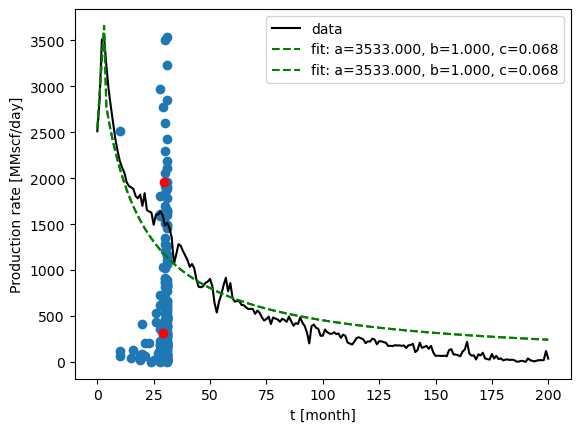

In [7]:
""" 데이터셋 구축 """
# for ipt in input_lst:
#     print()
no_fitting_lst = []
file = input_lst[2]
# for file in input_lst:
try:
    filename = file.strip('.csv')
    source = pd.read_csv(input_path + file)
    df = pd.DataFrame(source)
    # display(df.head())
    data = df.values
    used_period = len(data)

    xdata = data[0:used_period, 0]
    ydata = data[0:used_period, 12]
    plt.plot(xdata, ydata, 'k-', label='data')
    qi = np.max(data[:used_period, 12])
    check_idx = np.argmax(data[:used_period, 12])
    if check_idx != 0:
        xdata_lin = data[0:check_idx+1, 0]
        ydata_lin = data[0:check_idx+1, 12]
        xdata = data[check_idx+1:, 0]
        ydata = data[check_idx+1:, 12]
        popt_lin, _ = curve_fit(linear_model, xdata_lin, ydata_lin)
        ypred_lin = linear_model(xdata_lin, *popt_lin)   
        popt, pcov = curve_fit(arps_model, xdata, ydata, bounds=([qi, 1+1e-5, -math.inf], [qi+1e-5, math.inf, math.inf]), maxfev=5000)
        ypred_ori = arps_model(xdata, *popt)
        xdata = np.concatenate((xdata_lin, xdata))
        ypred = np.concatenate((ypred_lin, ypred_ori))
    else:
        popt, pcov = curve_fit(arps_model, xdata, ydata, bounds=([qi, 1+1e-5, -math.inf], [qi+1e-5, math.inf, math.inf]), maxfev=5000)
        ypred = arps_model(xdata, *popt)

    prodday = data[:, 2].reshape(-1, 1)
    prod = data[:, 5].reshape(-1, 1)
    prodrate = data[:, 12].reshape(-1, 1)

    data_cluster = np.concatenate([prodday, prodrate], axis=1)
    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data_cluster)
    distance_btw_center = distance.pdist(kmeans.cluster_centers_, metric='euclidean')

    plt.plot(xdata, ypred, 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    plt.xlabel('t [month]')
    plt.ylabel('Production rate [MMscf/day]')
    plt.legend()
    plt.savefig(fig_DC_fitting_path + filename)

    plt.plot(xdata, ypred, 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    plt.xlabel('t [month]')
    plt.ylabel('Production rate [MMscf/day]')
    plt.legend()
    plt.savefig(fig_DC_fitting_path + filename)

    plt.scatter(prodday, prodrate)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='r')
    plt.savefig(fig_cluster_path + filename)

    if distance_btw_center >= 5000 and np.abs(kmeans.cluster_centers_[:, 0][0] - kmeans.cluster_centers_[:, 0][1]) >= 15:
        plt.plot(xdata, ypred, 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        plt.xlabel('t [month]')
        plt.ylabel('Production rate [MMscf/day]')
        plt.legend()
        plt.savefig(fig_DC_fitting_path + filename)

        plt.scatter(prodday, prodrate)
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='r')
        plt.savefig(fig_cluster_path + filename)

    # plt.close()
except:
    no_fitting_lst.append(file)

In [15]:
no_fitting_lst

['30-015-32329.csv',
 '42-109-32221.csv',
 '42-109-32224.csv',
 '42-109-32229.csv']

[442.7876088]


c:\Users\User\anaconda3\envs\joko\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


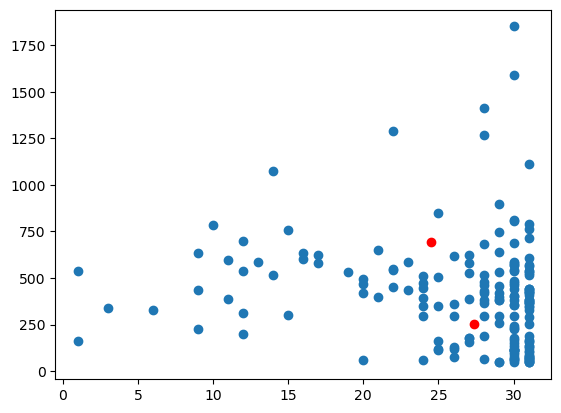

In [180]:
"""
갑자기 Clustering
"""
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler((0, 1))
# normed_data = scaler.fit_transform(data)
prodday = data[:, 2].reshape(-1, 1)
prod = data[:, 5].reshape(-1, 1)
prodrate = data[:, 12].reshape(-1, 1)

data_cluster = np.concatenate([prodday, prodrate], axis=1)
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data_cluster)
distance_btw_center = distance.pdist(kmeans.cluster_centers_, metric='euclidean')

print(distance_btw_center)
plt.scatter(prodday, prodrate)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='r')

In [178]:
distance_btw_center = distance.pdist(kmeans.cluster_centers_, metric='euclidean')
distance_btw_center

array([74121.44634709])